<a href="https://colab.research.google.com/github/supermop2525/GANTraining/blob/master/FMNIST_GAN_fillmein.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# * Setup

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.client import device_lib

# enable eager execution
tf.enable_eager_execution()

In [2]:
# check that TF can detect GPU
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1144579151869320435, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14733732283783819502
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 3691938493486969563
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11281553818
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3346976800071061394
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

# 1 Fashion MNIST Dataset

Load train/test datasets from API

In [3]:
# download the fashion mnist dataset
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [4]:
# examine dataset format
print("train images: type: {}; shape: {}".format(type(train_images), train_images.shape))
print("test images: type:  {}; shape: {}".format(type(test_images), test_images.shape))

# examine class frequency
print("train labels: {}".format([(a,b) for a, b in zip(np.unique(train_labels), np.bincount(train_labels))]))
print("test labels:  {}".format([(a,b) for a, b in zip(np.unique(test_labels), np.bincount(test_labels))]))

train images: type: <class 'numpy.ndarray'>; shape: (60000, 28, 28)
test images: type:  <class 'numpy.ndarray'>; shape: (10000, 28, 28)
train labels: [(0, 6000), (1, 6000), (2, 6000), (3, 6000), (4, 6000), (5, 6000), (6, 6000), (7, 6000), (8, 6000), (9, 6000)]
test labels:  [(0, 1000), (1, 1000), (2, 1000), (3, 1000), (4, 1000), (5, 1000), (6, 1000), (7, 1000), (8, 1000), (9, 1000)]


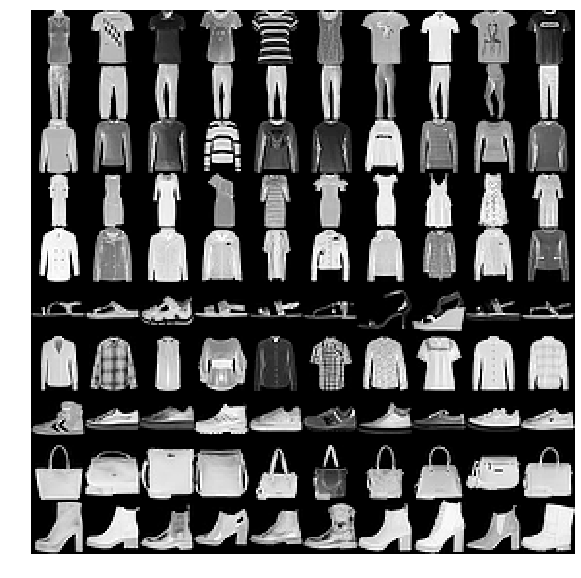

In [5]:
# visualize some of the images by randomly sampling a few images from each class
img_samples = []
for cls in list(np.unique(train_labels)):
    indices = np.where(train_labels==cls)[0]    
    samples = np.random.choice(a=indices, size=10, replace=False)
    img_samples.append(train_images[samples,:,:])
img_samples = tf.constant(np.concatenate(img_samples))
img_samples = tf.expand_dims(img_samples, 3)

# generate a 10 x 10 image grid
img_grid = tf.contrib.gan.eval.image_grid(
                input_tensor=img_samples,
                grid_shape=(10,10),
                image_shape=(28,28),
                num_channels=1
            )

# plot the image grid
plt.figure(figsize=(10,10))
plt.imshow(img_grid[0,:,:,0], cmap='gray')
plt.axis('off')
plt.show()

# 2 GAN Models

In [0]:
# Import keras modules that we will be using to construct our models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, ReLU, Activation, Flatten, Conv2D, LeakyReLU, 
    Conv2DTranspose, Input, Reshape, BatchNormalization
)

In [7]:
# create an image batch for testing model functionalities
images = train_images[:64,:,:]/128. - 1.
images = tf.constant(images, dtype=tf.float32)
images = tf.expand_dims(images, 3)
images.shape

TensorShape([Dimension(64), Dimension(28), Dimension(28), Dimension(1)])

In [0]:
# input image shape information
H, W, C =28, 28, 1
LATENT_DIM=16

# alpha param for leaky ReLu
ALPHA = 0.2

### Discriminator

Note: for a really good introduction to 2D-convolution operation for image processing, please check out: https://www.youtube.com/watch?time_continue=422&v=z9wiDg0w-Dc (time 2:29)


In [0]:
def build_discriminator():
    return Sequential([
        # reshape input layer
        Reshape((H, W, C), input_shape=(H, W)),
        
        # <TODO>
        # 1st conv2D layer + leaky relu
        # (filters=32, kernel_size=5, strides=2, padding='same')
        Conv2D(filters=32, kernel_size=5, strides=2, padding='same'),
        LeakyReLU(ALPHA),
        # 2nd conv2D layer
        # (filters=64, kernel_size=5, strides=2, padding='same')
        Conv2D(filters=64, kernel_size=5, strides=2, padding='same'),
        LeakyReLU(ALPHA),
        
        # 3rd conv2D layer
        # (filters=128, kernel_size=5, strides=2, padding='same')
        Conv2D(filters=128, kernel_size=5, strides=2, padding='same'),
        LeakyReLU(ALPHA),
        
        # Flatten conv2D output
        Flatten(),
        # Output layer (units=1)
        Dense(units=1),
        # Sigmoid activation 
        Activation('tanh')
    ])
      
      
def compute_d_loss(d_logits_real, d_logits_fake):
    """
    loss computation for the discriminator net
    """
    # Hinge loss
    real_loss = tf.reduce_mean(tf.nn.relu(1. - d_logits_real))
    fake_loss = tf.reduce_mean(tf.nn.relu(1. + d_logits_fake))

    return real_loss + fake_loss

In [10]:
# build discriminator model
d_net = build_discriminator()
print(d_net.summary())

# unit test by passing an images batch to the discriminator model
test = d_net(images)
print('\ndiscriminator loss: ', compute_d_loss(test, test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         204928    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 4, 4, 128)         0         
__________

### Generator

Note: for a great explanation on batch normalization (from everyone's favorite Andrew Ng): https://www.youtube.com/watch?v=nUUqwaxLnWs

In [0]:
def build_generator():
    return Sequential([

        # fully connected layer on latent vector + batch norm + leaky relu
        Dense(units=(H/4)*(W/4)*64, use_bias=False, input_shape=[LATENT_DIM]),
        BatchNormalization(),
        LeakyReLU(ALPHA),

        # <TODO>
        # reshape 1-D tensor into 3-D tensor
        Reshape(((H/4), (W/4), 64)),
        # 1st conv2d transpose operation + batch norm + leaky relu
        # filters=64, kernel_size=5, strides=1, padding='same', use_bias=False
        Conv2DTranspose(filters=64, kernel_size=5, strides=1, padding='same', use_bias=False),
        BatchNormalization(),
        LeakyReLU(ALPHA),
        # 2nd conv2d transpose operation + batch norm + leaky relu
        # filters=32, kernel_size=5, strides=2, padding='same', use_bias=False
        Conv2DTranspose(filters=32, kernel_size=5, strides=2, padding='same', use_bias=False),
        BatchNormalization(),
        LeakyReLU(ALPHA),
        # 3rd deconv operation
        # filters=C, kernel_size=5, strides=2, padding='same', use_bias=False
        Conv2DTranspose(filters=C, kernel_size=5, strides=2, padding='same', use_bias=False),
        # output operation
        Activation('tanh'),
    ])

      
def compute_g_loss(d_logits_fake):
    return - tf.reduce_mean(d_logits_fake)

In [12]:
# build generator network
g_net = build_generator()
print(g_net.summary())

# unit test by feeding in a batch of randomly generated latent vectors 
# into generator network
z_test = tf.random_normal(shape=(64, LATENT_DIM), dtype='float32')
test = g_net(z_test)
test_logit = d_net.call(test)
print('\ndiscriminator loss on generated images: ', compute_g_loss(test_logit))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3136)              50176     
_________________________________________________________________
batch_normalization (BatchNo (None, 3136)              12544     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 3136)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 64)          102400    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 64)          0         
__________

# 3 Model Training

### Setup

In [0]:
# training configuration information
SAMPLE_PER_N_STEPS=200

# training batch size & epoch
BUFFER_SIZE=1000
EPOCHS = 10
BATCH_SIZE = 128

### Optimizers

In [0]:
# learning rates
G_LR = 0.0001
D_LR = 0.0004

# beta params for the Adam optimizer
BETA1 = 0.0
BETA2 = 0.999

# generator optimizer
g_optimizer = tf.train.AdamOptimizer(learning_rate=G_LR, 
                                     beta1=BETA1, 
                                     beta2=BETA2)

# discriminator optimizer
d_optimizer = tf.train.AdamOptimizer(learning_rate=D_LR, 
                                     beta1=BETA1, 
                                     beta2=BETA2)

### Data Pipeline

In [0]:
# combine the train/test datasets because we won't be needing the test dataset
dataset = np.concatenate((train_images, test_images))

# convert dataset to 4-D tensor object format (batch, height, width, channel)
dataset = tf.constant(dataset, dtype=tf.float32)
dataset = tf.expand_dims(dataset, 3)

# create a tf.dataset object that will act as our input pipeline to feed data
# to our models during training
dataset = tf.data.Dataset.from_tensor_slices(dataset)

# we will pre-program how the tf.dataset object will be feeding in data batches
dataset = dataset.map(lambda x: (x / 128.) - 1., num_parallel_calls=4)\
                 .shuffle(BUFFER_SIZE)\
                 .repeat(EPOCHS)\
                 .batch(BATCH_SIZE)

In [16]:
dataset

<BatchDataset shapes: (?, 28, 28, 1), types: tf.float32>

### Training

training step 100: discriminator loss 0.5798126459121704; generator loss 0.541908860206604
training step 200: discriminator loss 0.5147592425346375; generator loss 0.5773470997810364


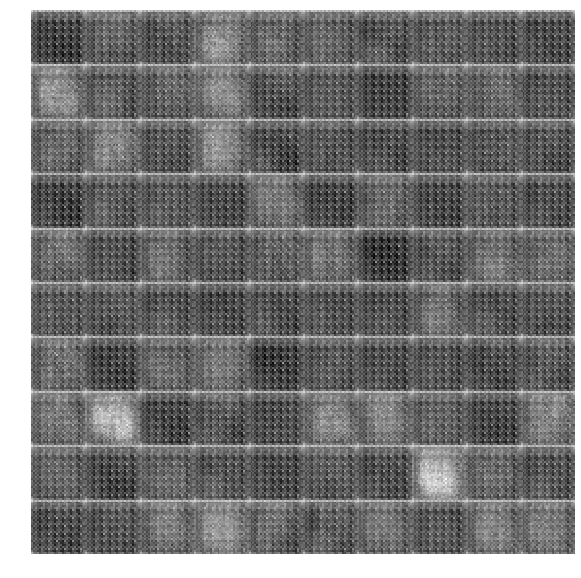

training step 300: discriminator loss 0.8050435185432434; generator loss 0.25219064950942993
training step 400: discriminator loss 1.111807107925415; generator loss 0.1899995654821396


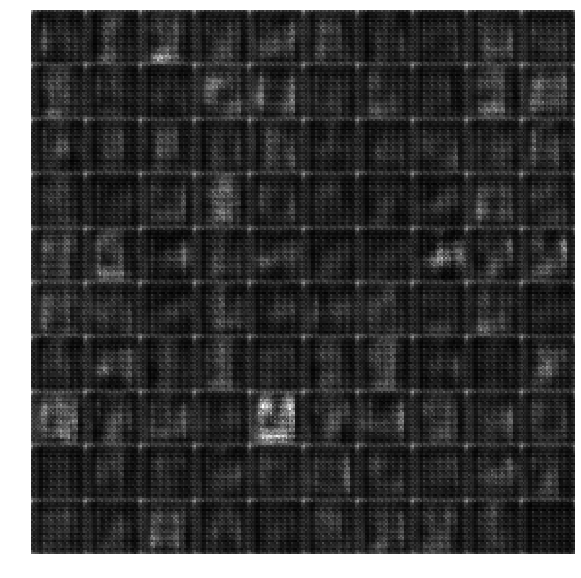

training step 500: discriminator loss 1.675088882446289; generator loss -0.41983333230018616
training step 600: discriminator loss 1.8245831727981567; generator loss -0.7863130569458008


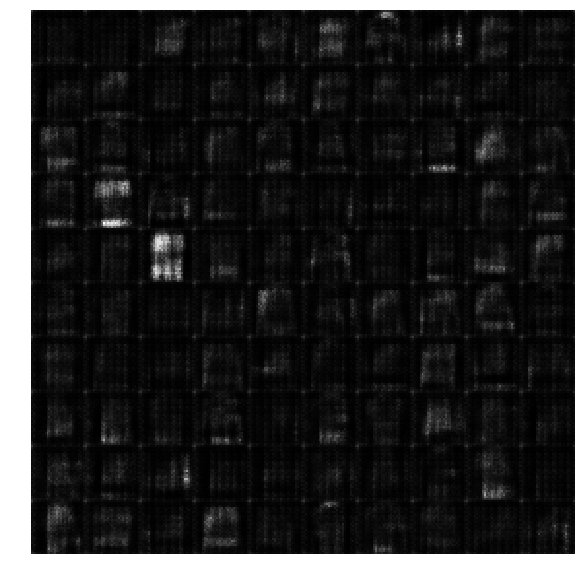

training step 700: discriminator loss 1.598846197128296; generator loss -0.4834664463996887
training step 800: discriminator loss 1.7252308130264282; generator loss -0.6584294438362122


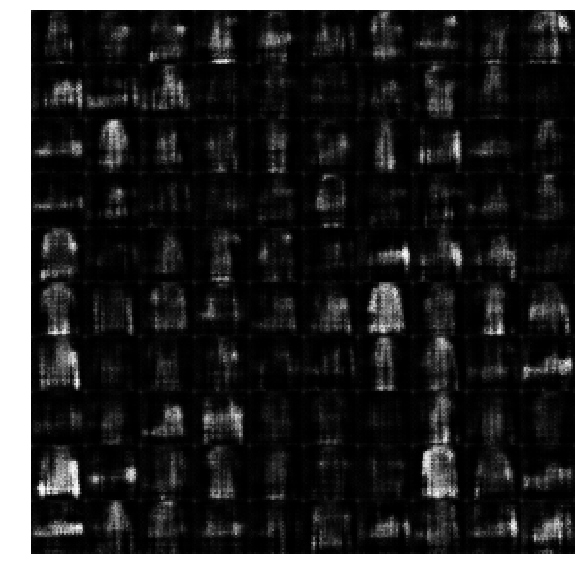

training step 900: discriminator loss 1.382129192352295; generator loss -0.17606741189956665
training step 1000: discriminator loss 1.2473362684249878; generator loss 0.09962841868400574


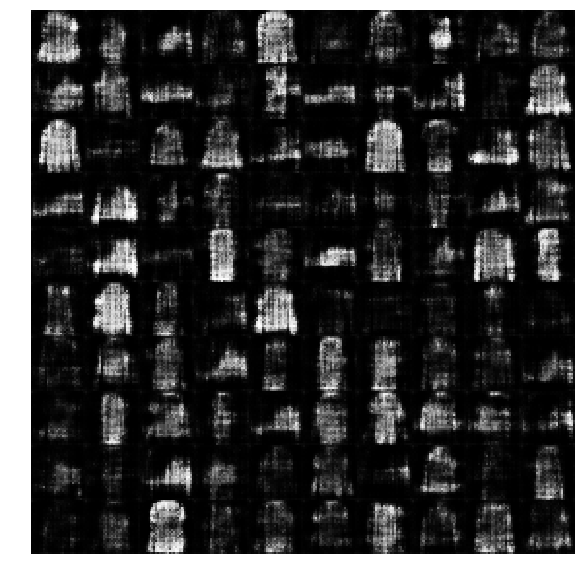

training step 1100: discriminator loss 1.1733533143997192; generator loss 0.19984035193920135
training step 1200: discriminator loss 1.2953855991363525; generator loss 0.8361650705337524


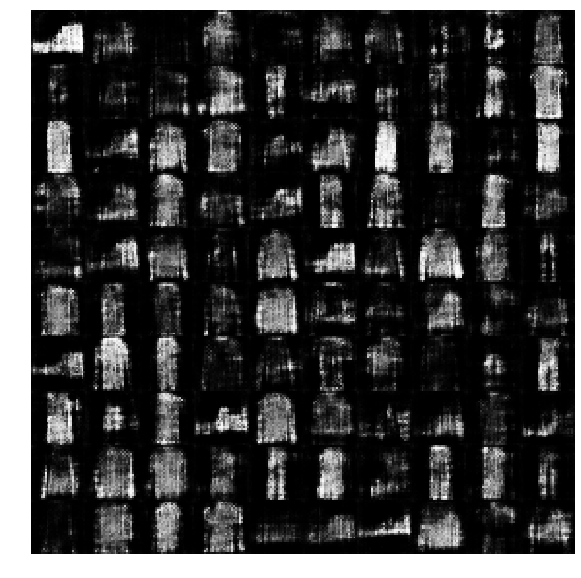

training step 1300: discriminator loss 1.1690654754638672; generator loss 0.20131169259548187
training step 1400: discriminator loss 1.451637864112854; generator loss 0.7977696061134338


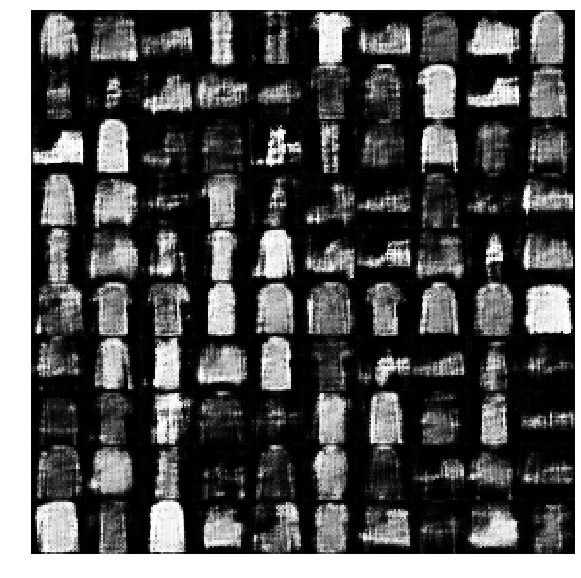

training step 1500: discriminator loss 1.338151454925537; generator loss 0.0709320604801178
training step 1600: discriminator loss 1.426837682723999; generator loss 0.9041756391525269


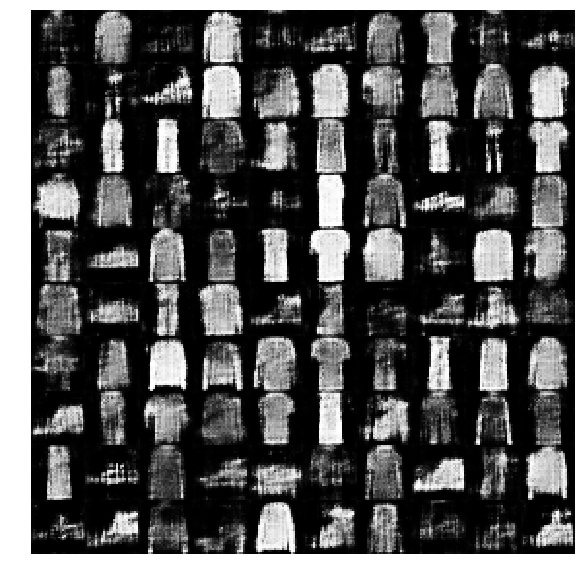

training step 1700: discriminator loss 1.2543703317642212; generator loss 0.8558403253555298
training step 1800: discriminator loss 1.1932874917984009; generator loss 0.8057696223258972


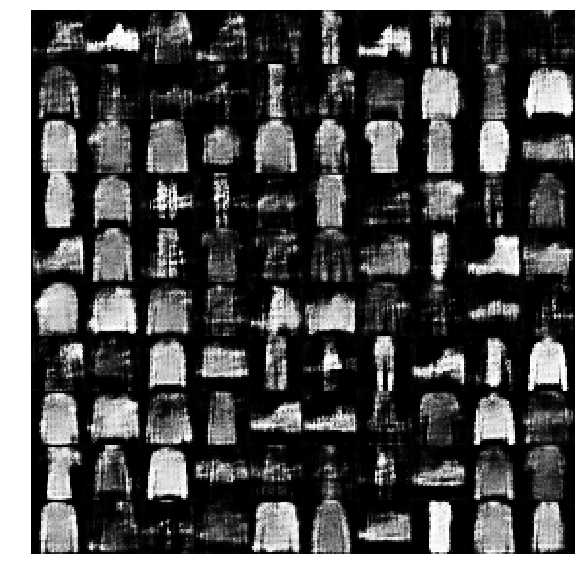

training step 1900: discriminator loss 1.1808143854141235; generator loss 0.7227203249931335
training step 2000: discriminator loss 1.4346612691879272; generator loss -0.31422409415245056


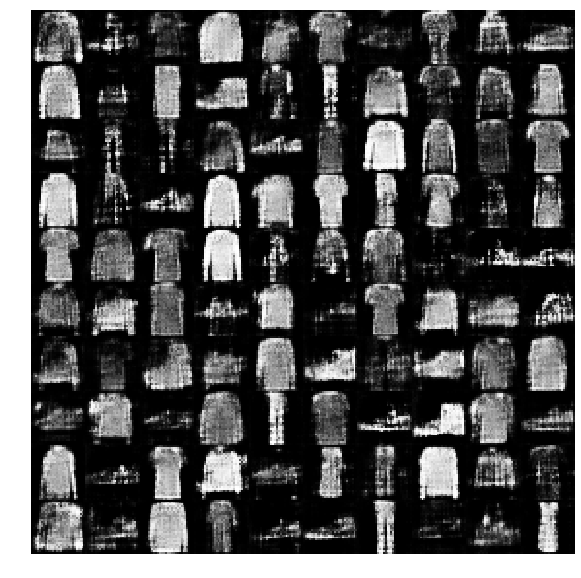

training step 2100: discriminator loss 1.142212152481079; generator loss 0.644711971282959
training step 2200: discriminator loss 1.4394075870513916; generator loss 0.9127243757247925


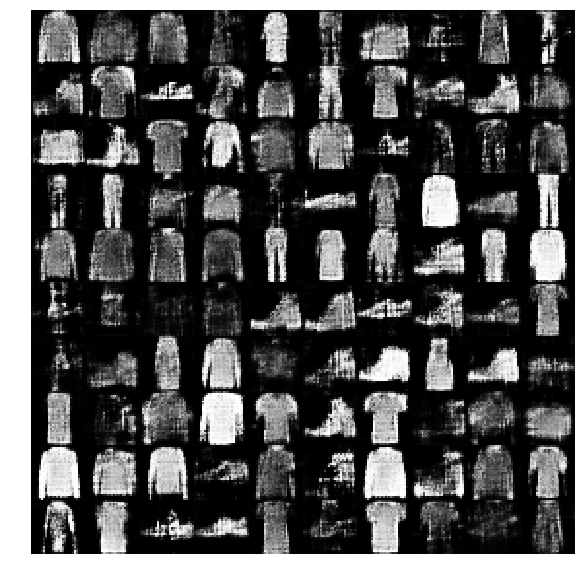

training step 2300: discriminator loss 1.1137232780456543; generator loss 0.4704304337501526
training step 2400: discriminator loss 1.136135220527649; generator loss 0.6020567417144775


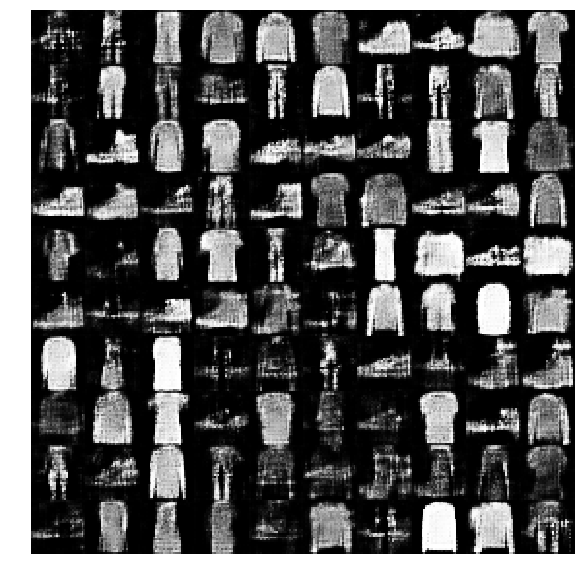

training step 2500: discriminator loss 1.3582020998001099; generator loss 0.7867594957351685
training step 2600: discriminator loss 1.184880018234253; generator loss 0.2663574814796448


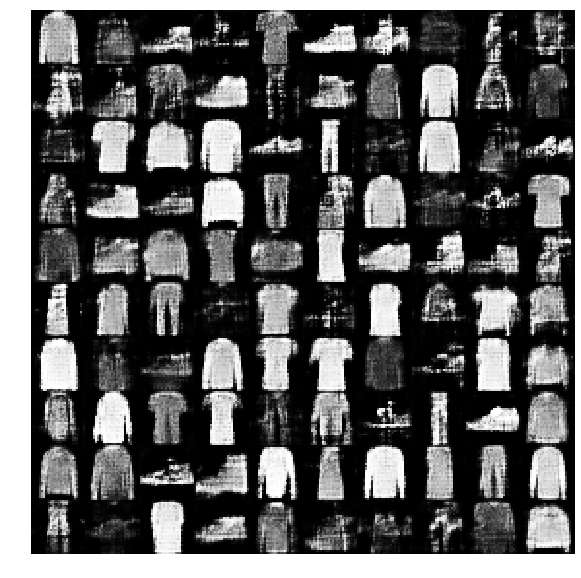

training step 2700: discriminator loss 1.329849123954773; generator loss 0.16603904962539673
training step 2800: discriminator loss 1.540932059288025; generator loss -0.3952066898345947


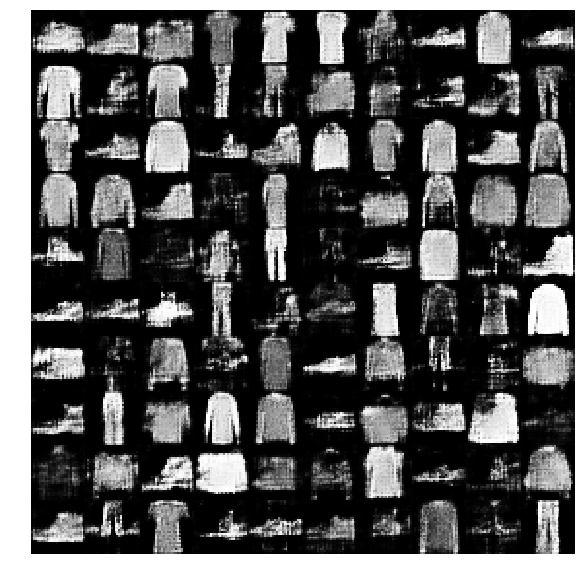

training step 2900: discriminator loss 1.3761953115463257; generator loss 0.8898743391036987
training step 3000: discriminator loss 1.245633602142334; generator loss 0.5773321390151978


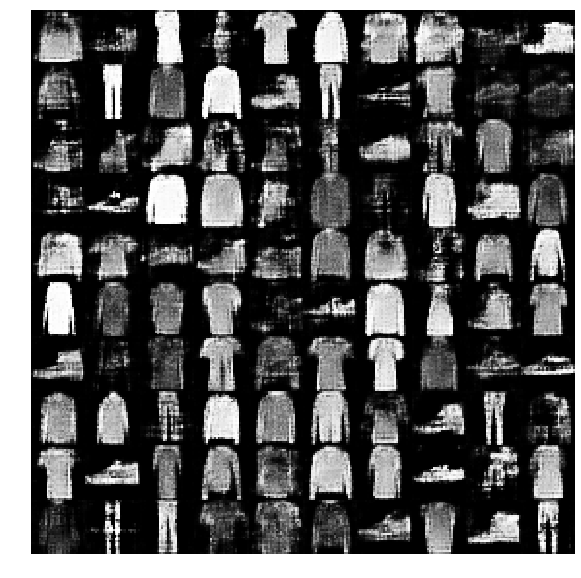

training step 3100: discriminator loss 1.1800005435943604; generator loss 0.2616129517555237
training step 3200: discriminator loss 1.3652896881103516; generator loss 0.11481477320194244


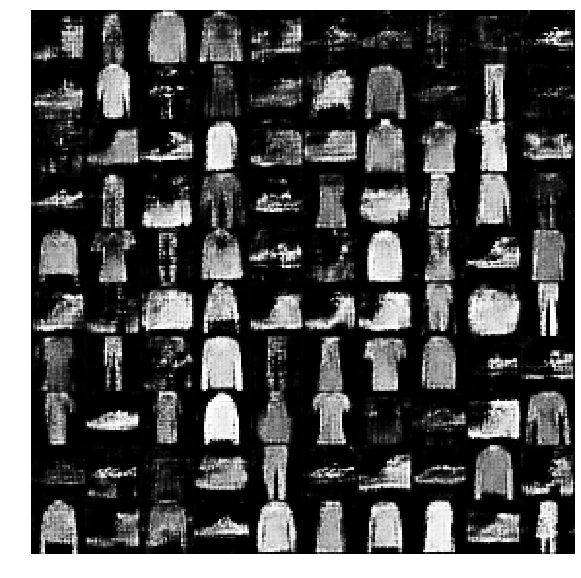

training step 3300: discriminator loss 1.3609672784805298; generator loss 0.5915849208831787
training step 3400: discriminator loss 1.3862810134887695; generator loss 0.8427196741104126


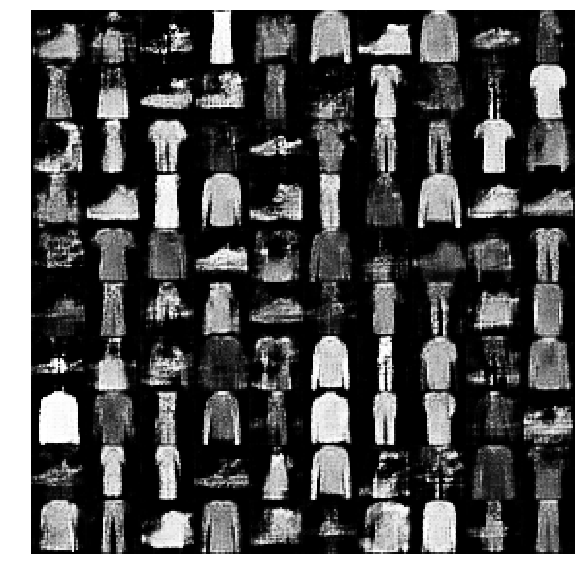

training step 3500: discriminator loss 1.4071052074432373; generator loss 0.8758993148803711
training step 3600: discriminator loss 1.1685614585876465; generator loss 0.5785188674926758


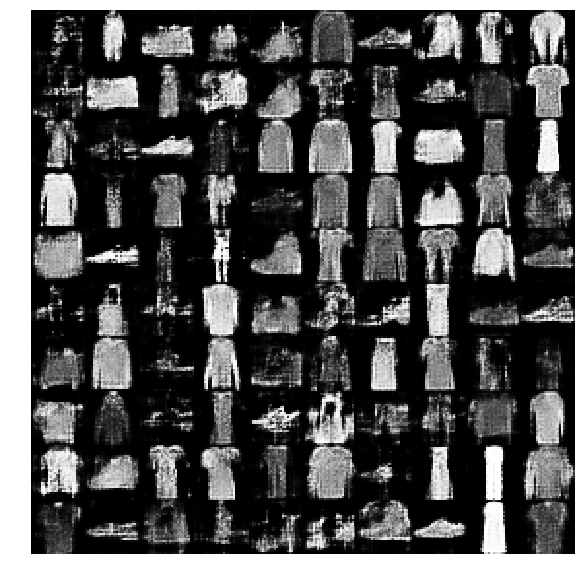

training step 3700: discriminator loss 1.2070727348327637; generator loss 0.6604492664337158
training step 3800: discriminator loss 1.2214291095733643; generator loss 0.8192906379699707


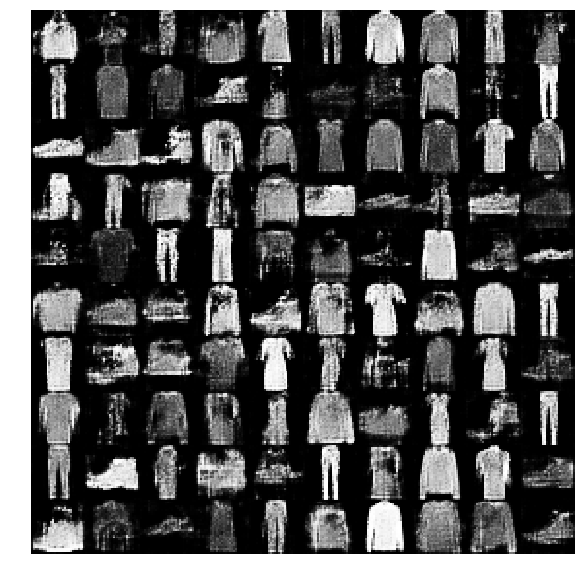

training step 3900: discriminator loss 1.196894884109497; generator loss 0.6060829162597656
training step 4000: discriminator loss 1.3279175758361816; generator loss 0.9306330680847168


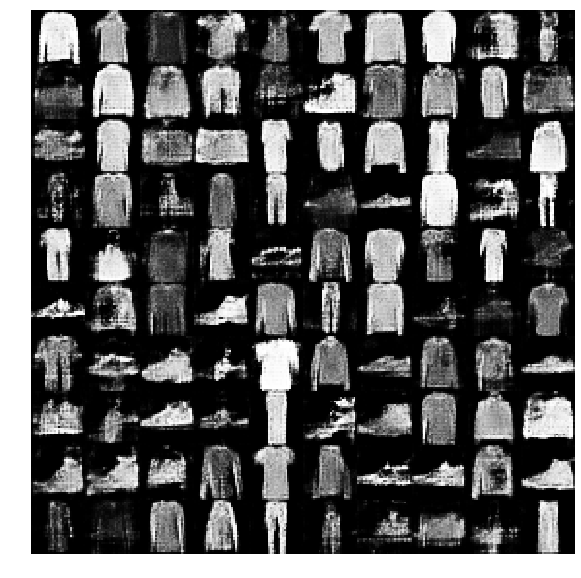

training step 4100: discriminator loss 1.2668944597244263; generator loss 0.055403806269168854
training step 4200: discriminator loss 1.3079054355621338; generator loss -0.06520329415798187


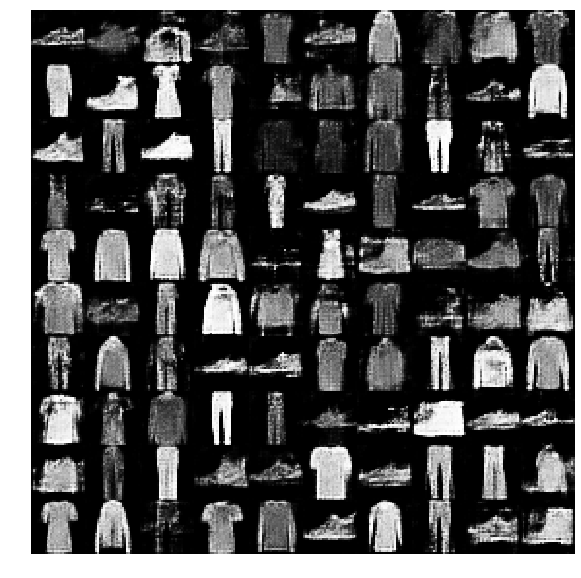

training step 4300: discriminator loss 1.0950071811676025; generator loss 0.34144723415374756
training step 4400: discriminator loss 1.2204535007476807; generator loss 0.8405713438987732


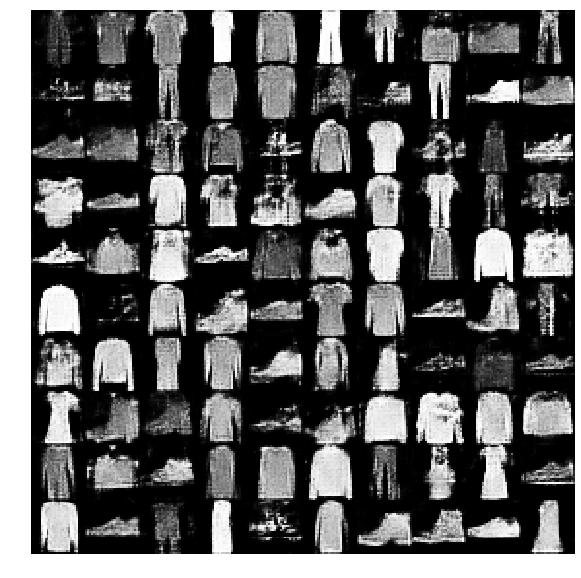

training step 4500: discriminator loss 1.2657554149627686; generator loss 0.09169337153434753
training step 4600: discriminator loss 1.1287482976913452; generator loss 0.6869688034057617


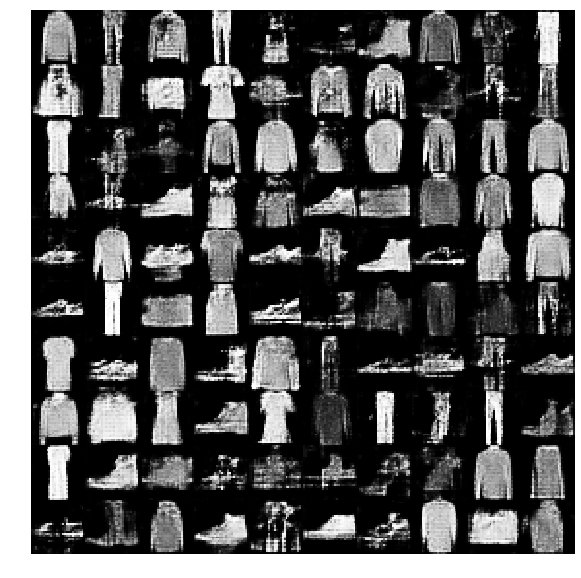

training step 4700: discriminator loss 1.2404887676239014; generator loss 0.20459099113941193
training step 4800: discriminator loss 1.4733299016952515; generator loss -0.1620747148990631


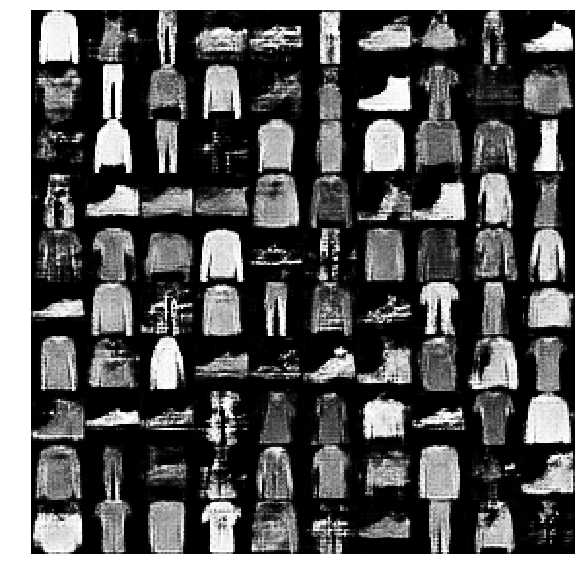

training step 4900: discriminator loss 1.2324551343917847; generator loss 0.7643783688545227
training step 5000: discriminator loss 1.0360336303710938; generator loss 0.8184270858764648


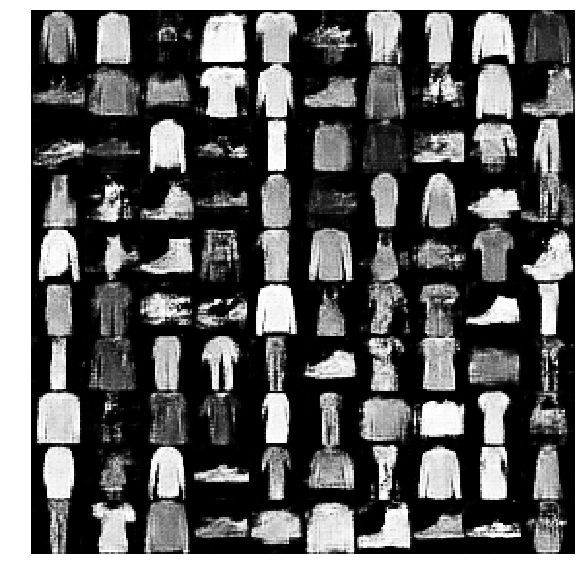

training step 5100: discriminator loss 1.442293405532837; generator loss 0.7735446095466614
training step 5200: discriminator loss 1.2163612842559814; generator loss 0.6633577346801758


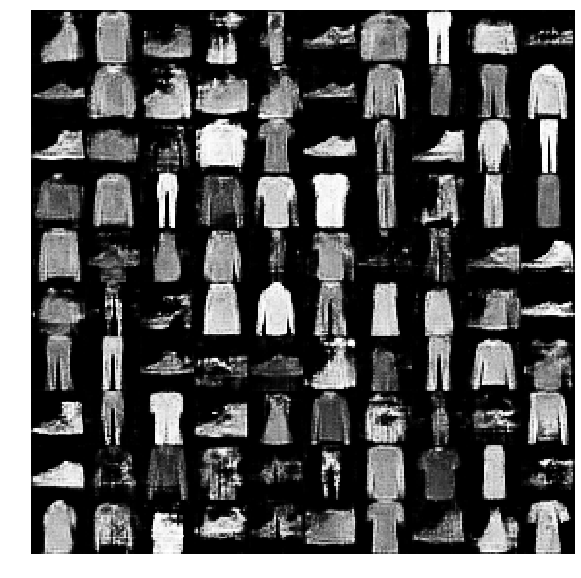

training step 5300: discriminator loss 1.0751521587371826; generator loss 0.6105341911315918
training step 5400: discriminator loss 1.187953233718872; generator loss 0.19595244526863098


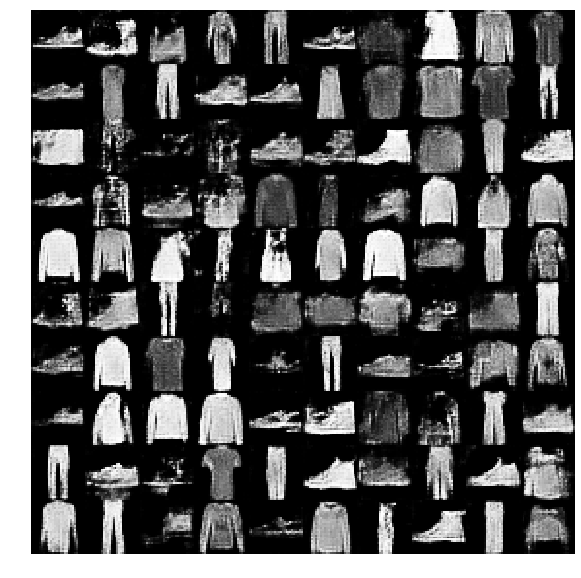

training step 5500: discriminator loss 1.3335227966308594; generator loss -0.06971803307533264
training step 5600: discriminator loss 1.1677520275115967; generator loss 0.13857829570770264


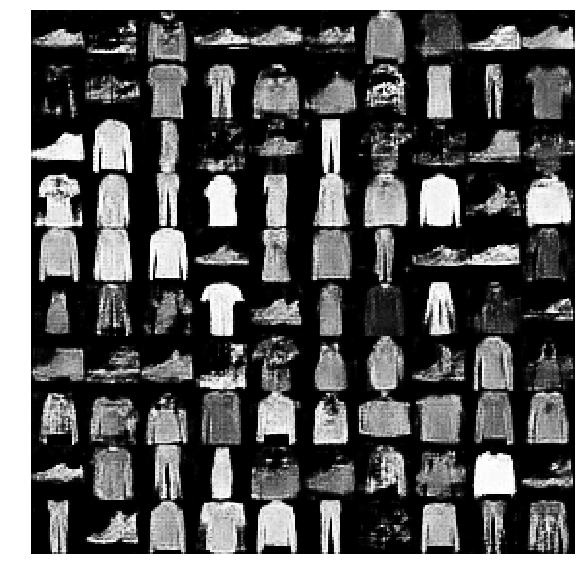

training step 5700: discriminator loss 1.2658452987670898; generator loss 0.24501089751720428
training step 5800: discriminator loss 1.2317577600479126; generator loss 0.14050103724002838


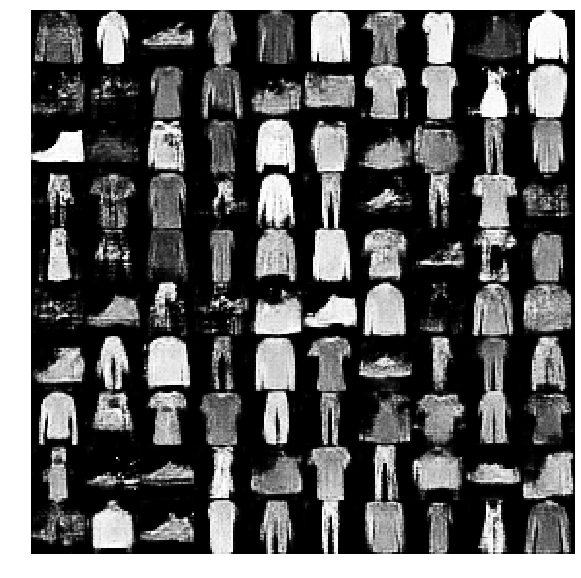

training step 5900: discriminator loss 1.138765811920166; generator loss 0.7431454658508301
training step 6000: discriminator loss 1.23760187625885; generator loss 0.05848631262779236


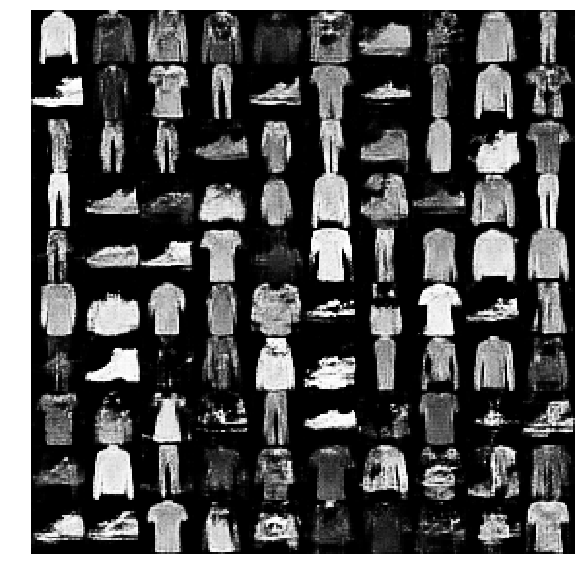

training step 6100: discriminator loss 1.1279205083847046; generator loss 0.3058070242404938
training step 6200: discriminator loss 1.0284136533737183; generator loss 0.5223544836044312


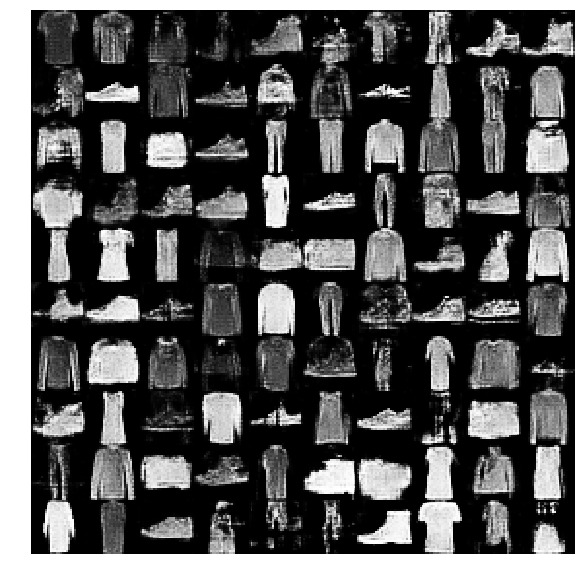

training step 6300: discriminator loss 1.1147445440292358; generator loss 0.3534119129180908
training step 6400: discriminator loss 1.108599066734314; generator loss 0.775732696056366


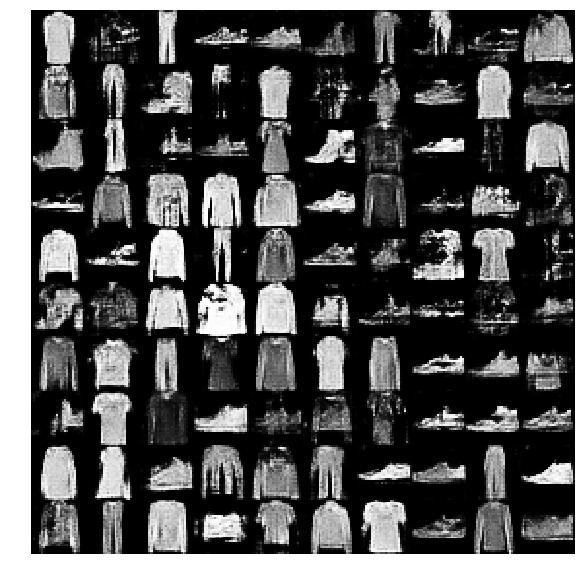

training step 6500: discriminator loss 1.0770293474197388; generator loss 0.17917472124099731
training step 6600: discriminator loss 1.4682302474975586; generator loss 0.8284919857978821


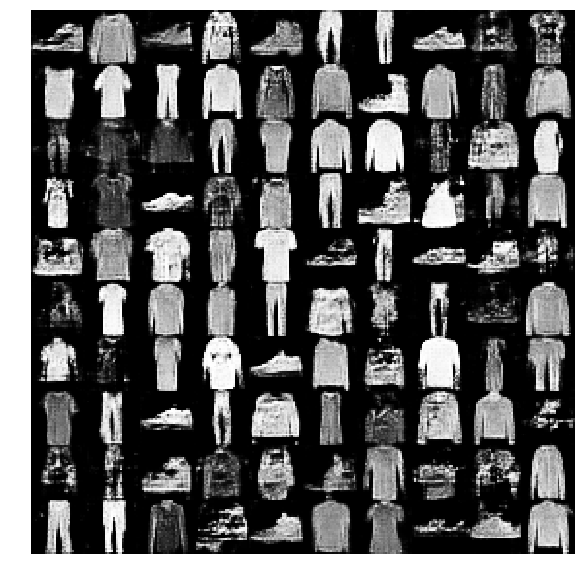

training step 6700: discriminator loss 1.066416621208191; generator loss 0.16594602167606354
training step 6800: discriminator loss 1.1454838514328003; generator loss 0.8754028081893921


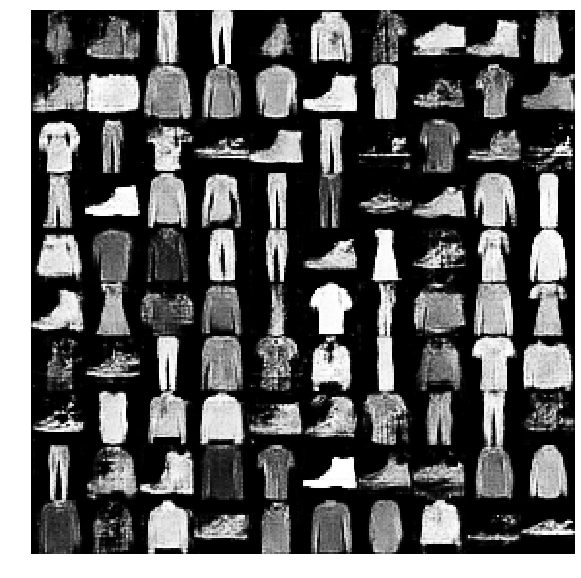

training step 6900: discriminator loss 1.2284488677978516; generator loss -0.0338408462703228
training step 7000: discriminator loss 1.0408995151519775; generator loss 0.6434354186058044


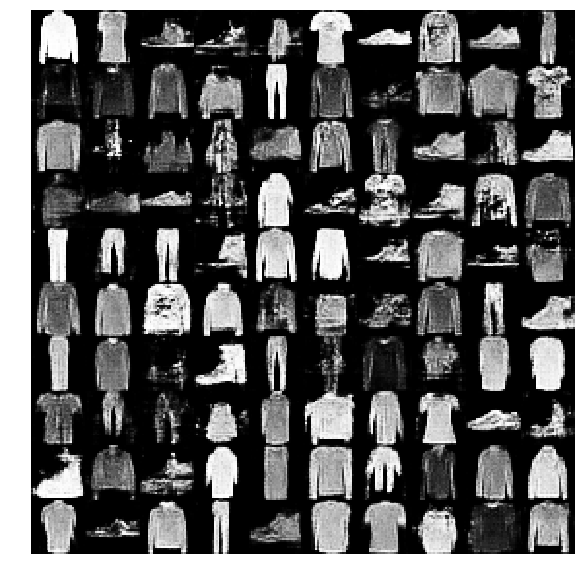

training step 7100: discriminator loss 1.1557738780975342; generator loss 0.8496974110603333
training step 7200: discriminator loss 1.2143759727478027; generator loss 0.6164563894271851


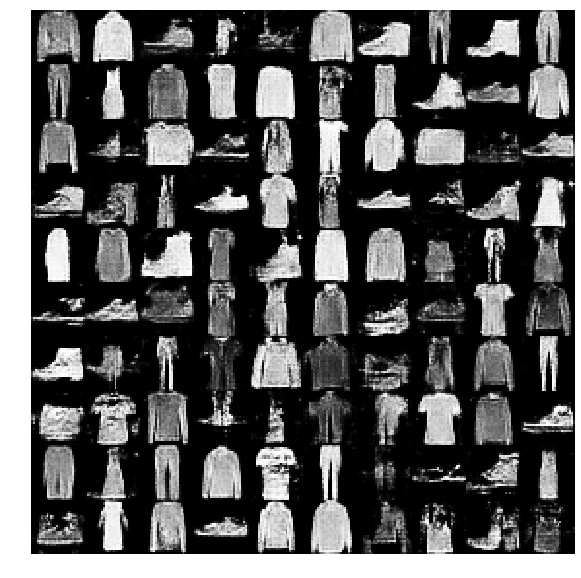

training step 7300: discriminator loss 1.1008299589157104; generator loss 0.17868337035179138
training step 7400: discriminator loss 1.2092821598052979; generator loss 0.23446303606033325


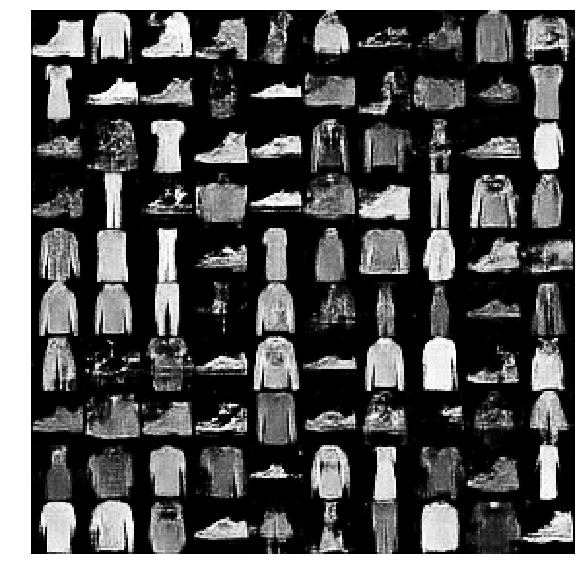

training step 7500: discriminator loss 1.3936291933059692; generator loss 0.9282195568084717
training step 7600: discriminator loss 1.0434730052947998; generator loss 0.6591333746910095


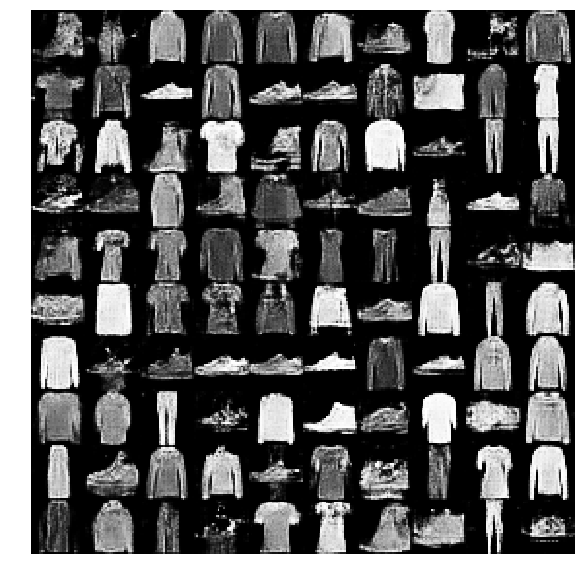

training step 7700: discriminator loss 1.125260829925537; generator loss 0.8268299698829651
training step 7800: discriminator loss 1.0384842157363892; generator loss 0.2085300236940384


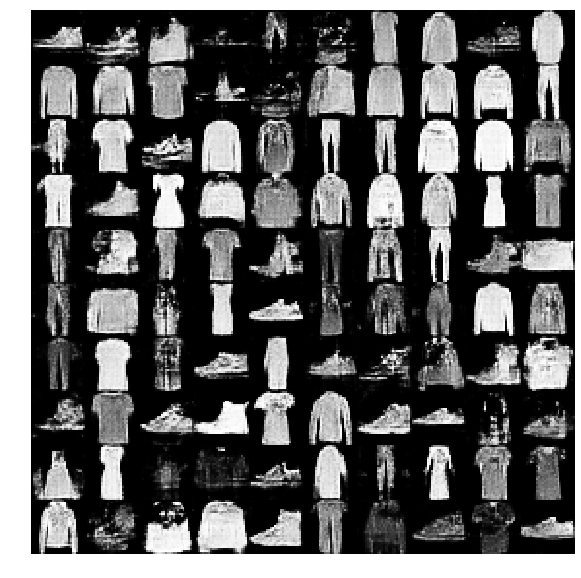

training step 7900: discriminator loss 0.8549153804779053; generator loss 0.8249337673187256
training step 8000: discriminator loss 1.248380422592163; generator loss 0.3170696496963501


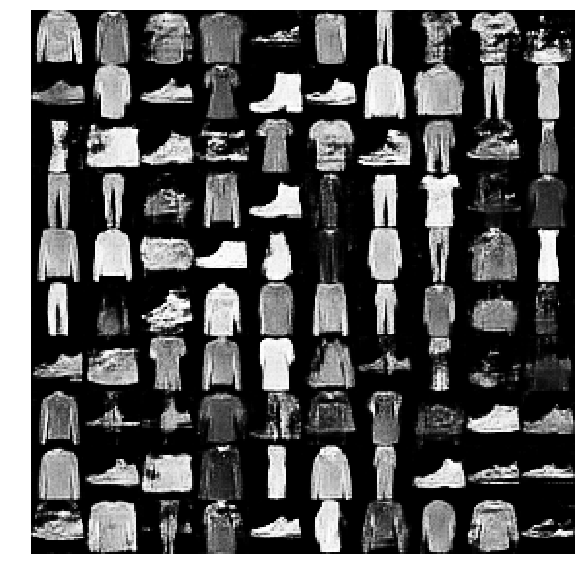

training step 8100: discriminator loss 1.118854284286499; generator loss 0.5215714573860168
training step 8200: discriminator loss 1.3552981615066528; generator loss 0.6691112518310547


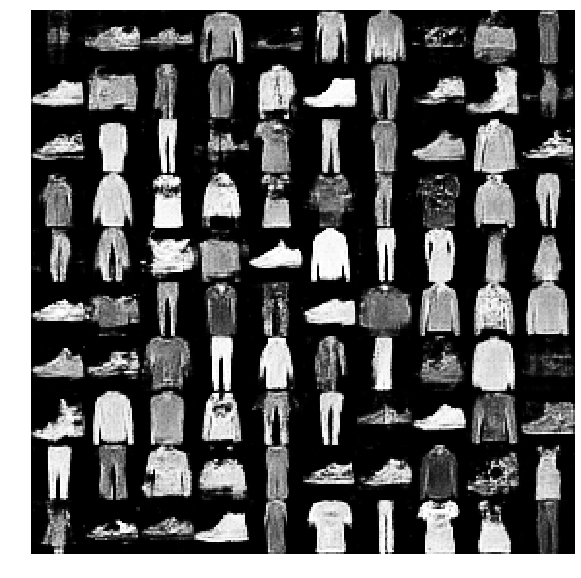

training step 8300: discriminator loss 1.042690396308899; generator loss 0.7574697732925415
training step 8400: discriminator loss 1.2027744054794312; generator loss 0.19260278344154358


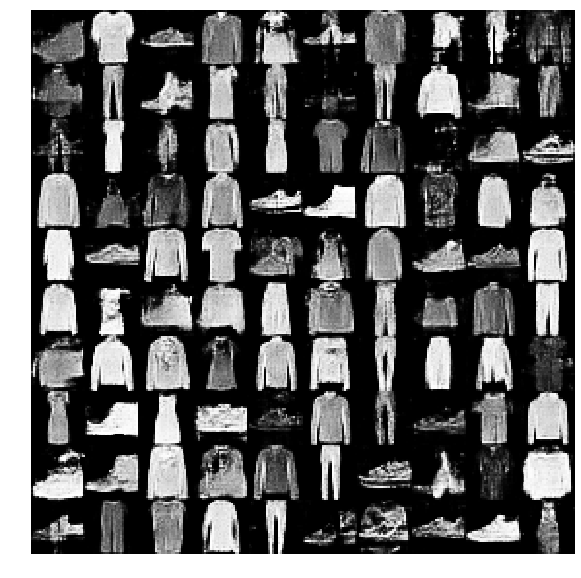

training step 8500: discriminator loss 1.0858018398284912; generator loss 0.4453640580177307
training step 8600: discriminator loss 1.0907115936279297; generator loss 0.8088459372520447


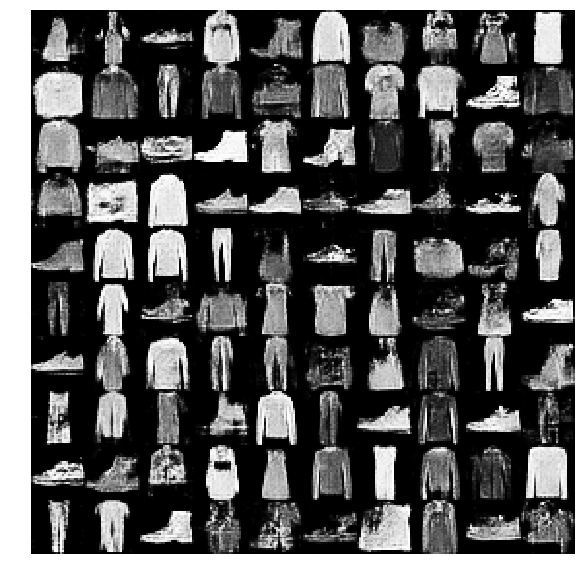

training step 8700: discriminator loss 0.9375143051147461; generator loss 0.5922678709030151
training step 8800: discriminator loss 0.9733366966247559; generator loss 0.8137587308883667


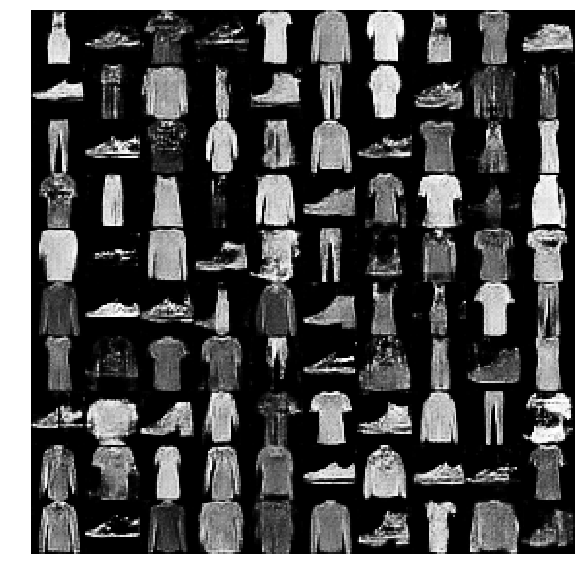

training step 8900: discriminator loss 1.0336552858352661; generator loss 0.21189004182815552
training step 9000: discriminator loss 1.3102837800979614; generator loss 0.3833809792995453


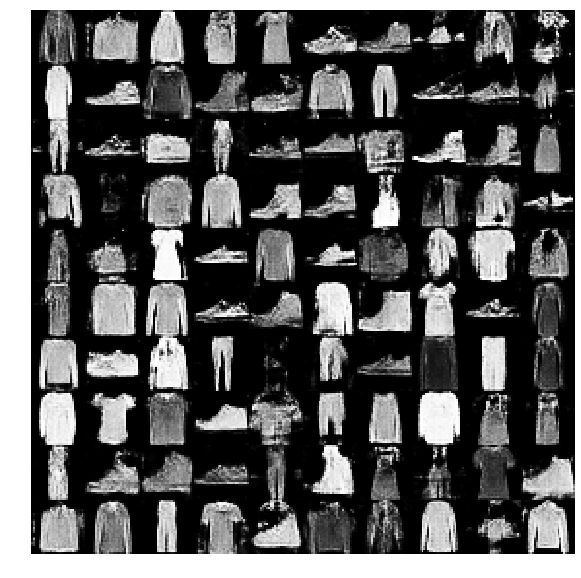

training step 9100: discriminator loss 1.0860111713409424; generator loss 0.6713441610336304
training step 9200: discriminator loss 1.1631441116333008; generator loss 0.36436405777931213


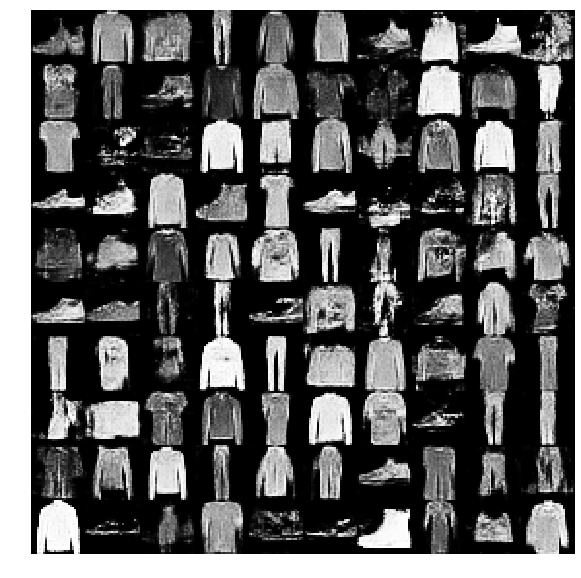

training step 9300: discriminator loss 1.0575358867645264; generator loss 0.7394524812698364
training step 9400: discriminator loss 1.1644225120544434; generator loss 0.24690239131450653


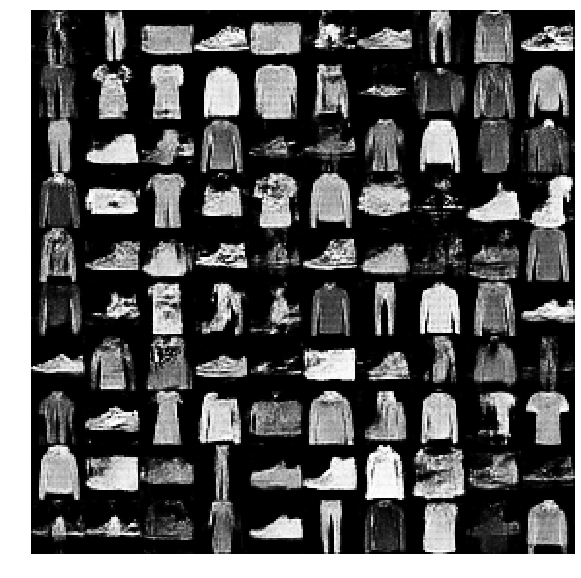

training step 9500: discriminator loss 1.2094194889068604; generator loss 0.033381059765815735
training step 9600: discriminator loss 1.0784857273101807; generator loss 0.2715657949447632


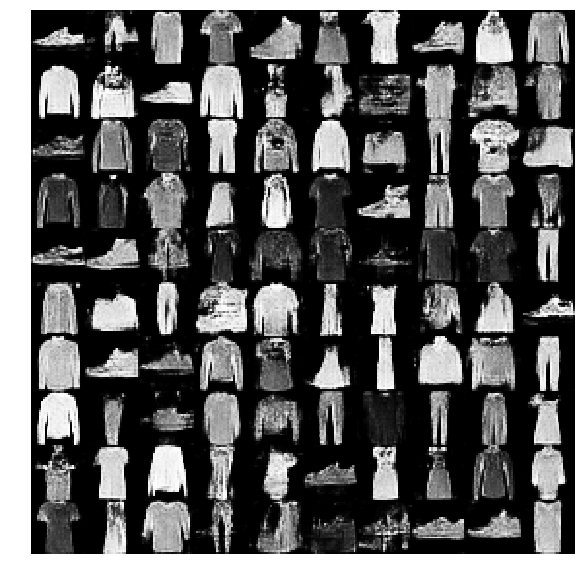

training step 9700: discriminator loss 1.2590117454528809; generator loss 0.35825949907302856
training step 9800: discriminator loss 1.121097445487976; generator loss 0.3282175362110138


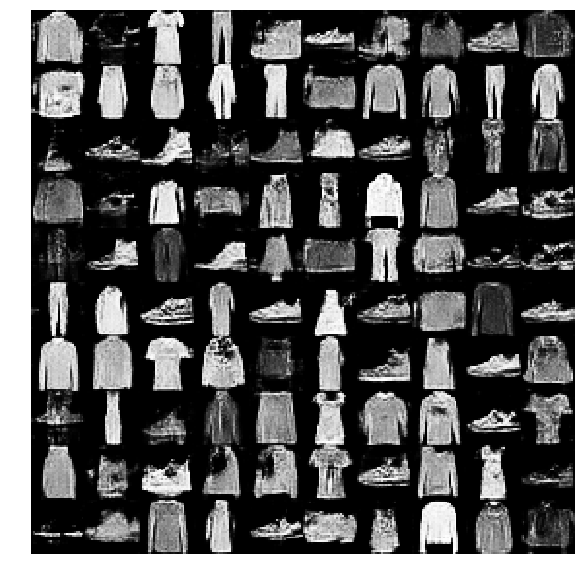

training step 9900: discriminator loss 1.0466036796569824; generator loss 0.6012735962867737
training step 10000: discriminator loss 0.9343671202659607; generator loss 0.49064481258392334


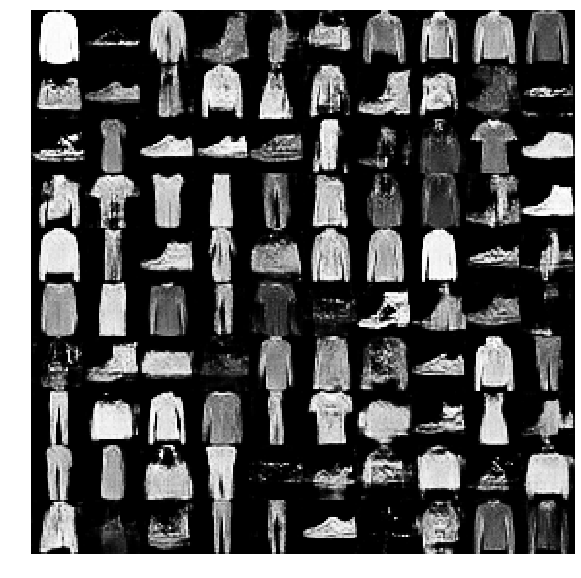

training step 10100: discriminator loss 1.0272226333618164; generator loss 0.6563118100166321
training step 10200: discriminator loss 1.0896124839782715; generator loss 0.6178154349327087


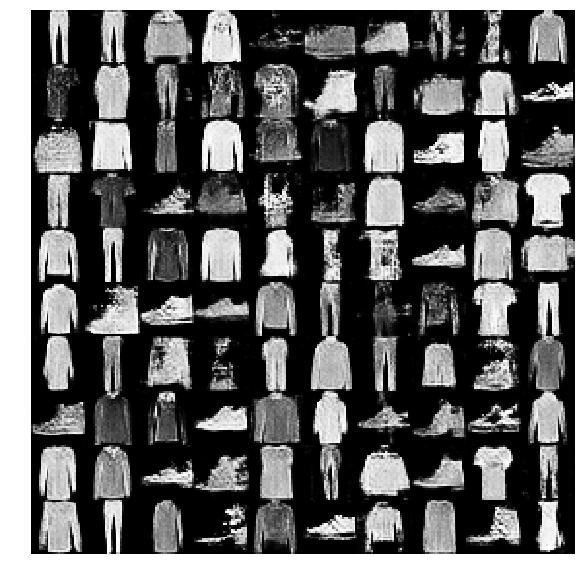

KeyboardInterrupt: ignored

In [17]:
# create global training step tracker object
global_step = tf.train.get_or_create_global_step()

# keep track of losses
d_losses, g_losses = [], []


for real_img_batch in dataset:

    # construct random normal z input to feed into generator
    input_z = tf.random_normal(shape=(BATCH_SIZE, LATENT_DIM), dtype='float32')

    # define gradient tapes to start recording computation operations
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
      

        # <TODO>
        # FORWARD RUN TO COMPUTE G/D-NET LOSSES
        # ----------------------------------------------------------------------
        # 1. run g_net with input_z to generate batch of fake images
        g_fake_images = g_net(input_z, training=True)  

        # 2. run d_net with the batch of generated fake images
        d_logits_fake = d_net(g_fake_images, training=True)
        
        # 3. run d_net with a batch of real images from dataset
        d_logits_real = d_net(real_img_batch, training=True)
        
        # 4. compute g_net losses with feedback from the d_net
        g_loss = compute_g_loss(d_logits_fake)
        g_losses.append(g_loss)
        
        # 5. compute d_net losses by revealing its logit values for both
        #    real and fake images
        d_loss = compute_d_loss(d_logits_real, d_logits_fake)
        d_losses.append(d_loss)
        
                          
        # UPDATE G/D-NET PARAMETERS
        # ----------------------------------------------------------------------
        # 1. get all learn-able G/D-net parameters (i.e. parameters to optimize)
        d_variables = d_net.variables
        g_variables = g_net.variables
                
        # 2. compute d(d_loss)/dx, d(g_loss)/dx
        d_grads = d_tape.gradient(d_loss, d_variables)
        g_grads = g_tape.gradient(g_loss, g_variables)

        # 3. apply gradient updates to the parameters
        d_optimizer.apply_gradients(zip(d_grads, d_variables),
                                    global_step=global_step)
        g_optimizer.apply_gradients(zip(g_grads, g_variables),
                                    global_step=global_step)

    
    # EVERY NOW & THEN, DISPLAY OUTPUT TO TRACK TRAINING PROGRESS
    # ----------------------------------------------------------------------
    # get training step
    step = global_step.numpy()
    
    # display losses every 100 steps
    if step % 100==0:
        print('training step {}: discriminator loss {}; generator loss {}'\
              .format(step, d_loss, g_loss))
    
    
    # display sample images every SAMPLE_PER_N_STEPS
    if step % SAMPLE_PER_N_STEPS==0:      
        
        # 1. create a batch of (100, LATENT_DIM) z-input tensor
        eval_z = tf.random_normal(shape=(100, LATENT_DIM), dtype='float32')

        # 2. generate images by using G-net
        eval_img = g_net(eval_z, training=False)
        
        # 3. organize the images into a grid
        img_grid = tf.contrib.gan.eval.image_grid(
                        input_tensor=eval_img,
                        grid_shape=(10,10),
                        image_shape=(H, W),
                        num_channels=C
                    )
                
        # 4. plot the image grid
        plt.figure(figsize=(10,10))
        plt.imshow(img_grid[0,:,:,0], cmap='gray')
        plt.axis('off')
        plt.show()